# Lesson 6: Transfer Learning, notebook 1: Cats and Dogs

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import PIL.Image as Image

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Part 1: Use a TensorFlow Hub MobileNet for prediction

In [3]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224
L = [
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
]
model = tf.keras.Sequential(L)

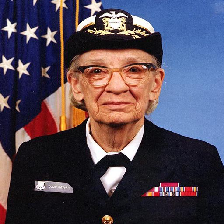

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper) / 255.
grace_hopper.shape

(224, 224, 3)

In [6]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0])
predicted_class

653

Text(0.5, 1.0, 'Prediction: Military Uniform')

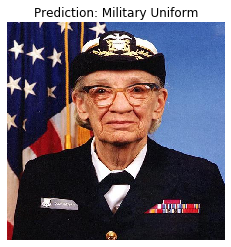

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title("Prediction: " + predicted_class_name.title())

## Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

In [9]:
splits = tfds.Split.ALL.subsplit(weighted=(80,20))
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [10]:
for i, example_image in enumerate(train_examples.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


In [11]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.
    return image, label

In [12]:
BATCH_SIZE = 32

# Why // 4?
# What is prefetch
train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Persian cat', 'Siamese cat', 'doormat', 'EntleBucher', 'bluetick',
       'Egyptian cat', 'redbone', 'Egyptian cat', 'paper towel',
       'black-and-tan coonhound', 'redbone', 'tabby', 'beagle',
       'tiger cat', 'Walker hound', 'bluetick', 'Shetland sheepdog',
       'Egyptian cat', 'Egyptian cat', 'tabby', 'tiger cat',
       'Siamese cat', 'tabby', 'Egyptian cat', 'keeshond',
       'Tibetan mastiff', 'bloodhound', 'Eskimo dog', 'schipperke',
       'tabby', 'German shepherd', 'chow'], dtype='<U30')

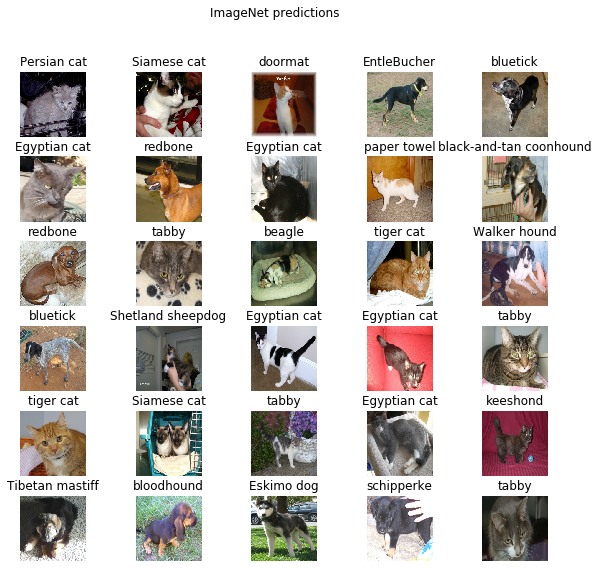

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES,IMAGE_RES,3))

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [17]:
feature_extractor.trainable = False

In [18]:
L = [
    feature_extractor,
    tf.keras.layers.Dense(2, activation='softmax')
]
model = tf.keras.Sequential(L)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 337s 578ms/step - loss: 0.0498 - accuracy: 0.9839 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 327s 562ms/step - loss: 0.0314 - accuracy: 0.9899 - val_loss: 0.0332 - val_accuracy: 0.9881
Epoch 3/6
582/582 [==============================] - 330s 567ms/step - loss: 0.0251 - accuracy: 0.9919 - val_loss: 0.0310 - val_accuracy: 0.9888
Epoch 4/6
582/582 [==============================] - 325s 558ms/step - loss: 0.0208 - accuracy: 0.9934 - val_loss: 0.0343 - val_accuracy: 0.9884
Epoch 5/6
582/582 [==============================] - 327s 561ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0410 - val_accuracy: 0.9851
Epoch 6/6
582/582 [==============================] - 329s 565ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0334 - val_accuracy: 0.9877


Text(0.5, 1.0, 'Training and Validation Loss')

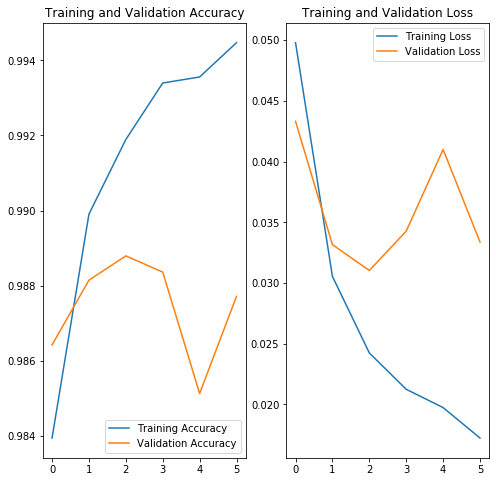

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [21]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [22]:
predicted_batch = model.predict(image_batch)
# What is this doing?
predicted_batch = tf.squeeze(predicted_batch).numpy()
# axis = -1?
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat',
       'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'dog', 'dog'], dtype='<U3')

In [23]:
print("Labels:", label_batch)
print("Predicted labels:", predicted_ids)

Labels: [0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1]
Predicted labels: [0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1]


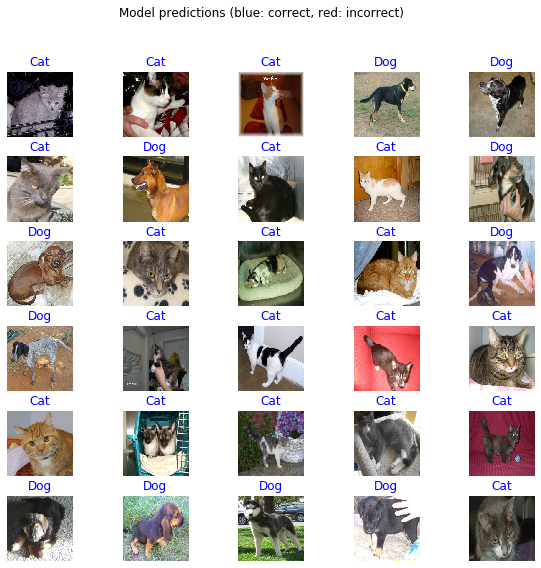

In [24]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")